In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import requests
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

from multiprocessing import Process, Queue

import pickle

from IPython.display import HTML

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Get data

In [ ]:
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
!unzip kion.zip

Archive:  kion.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [ ]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [ ]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'], format='%Y-%m-%d')
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


<AxesSubplot: >

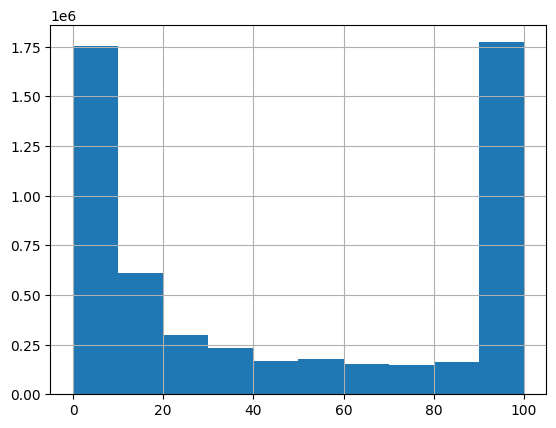

In [ ]:
interactions['watched_pct'].hist()

In [ ]:
interactions = interactions[interactions['watched_pct'] >= 50]

In [ ]:
interactions = interactions.sort_values(['user_id', 'last_watch_dt'])
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2354936,1,10440,2021-08-13,19579,80.0
71779,2,7571,2021-05-20,6151,100.0
809786,2,11577,2021-05-21,4974,98.0
1824303,2,16166,2021-05-21,5980,95.0
457283,2,4475,2021-05-30,7029,100.0


In [ ]:
sizes = interactions.groupby('user_id').size()
interactions = interactions[~interactions['user_id'].isin(sizes[sizes < 5].index)]
interactions.shape

(1634804, 5)

### Bert4Rec

Based on https://github.com/asash/bert4rec_repro

In [ ]:
!git clone https://github.com/asash/bert4rec_repro.git aprec

In [ ]:
!git clone https://github.com/asash/b4rvae.git b4rvae

In [ ]:
!pip install wget

#### Prepare data

In [ ]:
from aprec.api.action import Action

In [ ]:
interactions['timestamp'] = interactions['last_watch_dt'].astype('int')
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,timestamp
71779,2,7571,2021-05-20,6151,100.0,1621468800000000000
809786,2,11577,2021-05-21,4974,98.0,1621555200000000000
1824303,2,16166,2021-05-21,5980,95.0,1621555200000000000
457283,2,4475,2021-05-30,7029,100.0,1622332800000000000
1053393,2,6774,2021-05-30,5663,92.0,1622332800000000000


In [ ]:
interactions['watched_pct'].min()

50.0

In [ ]:
def get_kion_actions(data):
    for i, row in data.iterrows():
        yield Action(row['user_id'], row['item_id'], row['timestamp'], {"rating": row['watched_pct']})

In [ ]:
np.random.seed(2023) 
val_users = np.random.choice(interactions['user_id'].unique(), size=1000, replace=False).tolist()

#### Training

In [ ]:
from aprec.datasets.dataset_utils import filter_cold_users
from aprec.datasets.movielens20m import get_movies_catalog
from aprec.recommenders.bert4recrepro.b4vae_bert4rec import B4rVaeBert4Rec
from aprec.recommenders.filter_seen_recommender import FilterSeenRecommender
from aprec.utils.generator_limit import generator_limit
from tqdm.notebook import tqdm

In [ ]:
display(HTML(''))

recommender = B4rVaeBert4Rec(epochs=2)
recommender.args.device = 'cuda'
recommender.args.train_batch_size = 512
recommender.set_val_users(val_users)
recommender = FilterSeenRecommender(recommender)
for action in filter_cold_users(generator_limit(get_kion_actions(interactions), 10e5), 5):
    recommender.add_action(action)
recommender.rebuild_model()

Negative samples don't exist. Generating.
Sampling negative items



100%|██████████| 84718/84718 [00:00<00:00, 315086.15it/s]


Negative samples don't exist. Generating.
Sampling negative items



100%|██████████| 84718/84718 [03:14<00:00, 435.15it/s]

  0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.000, N@5 0.032, N@10 0.046, R@1 0.000, R@5 0.062, R@10 0.109:   0%|          | 0/662 [00:02<?, ?it/s]
Val: N@1 0.000, N@5 0.032, N@10 0.046, R@1 0.000, R@5 0.062, R@10 0.109:   0%|          | 1/662 [00:02<25:05,  2.28s/it]
Val: N@1 0.004, N@5 0.032, N@10 0.047, R@1 0.004, R@5 0.059, R@10 0.105:   0%|          | 1/662 [00:02<25:05,  2.28s/it]
Val: N@1 0.004, N@5 0.032, N@10 0.047, R@1 0.004, R@5 0.059, R@10 0.105:   0%|          | 2/662 [00:02<11:18,  1.03s/it]
Val: N@1 0.005, N@5 0.030, N@10 0.046, R@1 0.005, R@5 0.055, R@10 0.104:   0%|          | 2/662 [00:02<11:18,  1.03s/it]
Val: N@1 0.005, N@5 0.030, N@10 0.046, R@1 0.005, R@5 0.055, R@10 0.104:   0%|          | 3/662 [00:02<06:39,  1.65it/s]
Val: N@1 0.008, N@5 0.030, N@10 0.048, R@1 0.008, R@5 0.053, R@10 0.107:   0%|          | 3/662 [00:02<06:39,  1.65it/s]
Val: N@1 0.009, N@5 0.032, N@10 0.050, R@1 0.009, R@5 0.055, R@1

Update Best NDCG@10 Model at 1



Epoch 1, loss 7.344 : 100%|██████████| 166/166 [01:39<00:00,  1.68it/s]

  0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.383, N@5 0.553, N@10 0.600, R@1 0.383, R@5 0.711, R@10 0.859:   0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.383, N@5 0.553, N@10 0.598, R@1 0.383, R@5 0.711, R@10 0.852:   0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.383, N@5 0.553, N@10 0.598, R@1 0.383, R@5 0.711, R@10 0.852:   0%|          | 2/662 [00:00<00:47, 13.82it/s]
Val: N@1 0.370, N@5 0.526, N@10 0.577, R@1 0.370, R@5 0.669, R@10 0.826:   0%|          | 2/662 [00:00<00:47, 13.82it/s]
Val: N@1 0.377, N@5 0.527, N@10 0.573, R@1 0.377, R@5 0.666, R@10 0.809:   0%|          | 2/662 [00:00<00:47, 13.82it/s]
Val: N@1 0.377, N@5 0.527, N@10 0.573, R@1 0.377, R@5 0.666, R@10 0.809:   1%|          | 4/662 [00:00<00:49, 13.41it/s]
Val: N@1 0.380, N@5 0.529, N@10 0.577, R@1 0.380, R@5 0.666, R@10 0.812:   1%|          | 4/662 [00:00<00:49, 13.41it/s]
Val: N@1 0.392, N@5 0.538, N@10 0.584, R@1 0.392, R@5 0

Update Best NDCG@10 Model at 1



Epoch 2, loss 6.780 : 100%|██████████| 166/166 [01:40<00:00,  1.65it/s]

  0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.406, N@5 0.597, N@10 0.625, R@1 0.406, R@5 0.773, R@10 0.859:   0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.406, N@5 0.592, N@10 0.623, R@1 0.406, R@5 0.766, R@10 0.863:   0%|          | 0/662 [00:00<?, ?it/s]
Val: N@1 0.406, N@5 0.592, N@10 0.623, R@1 0.406, R@5 0.766, R@10 0.863:   0%|          | 2/662 [00:00<00:47, 13.83it/s]
Val: N@1 0.393, N@5 0.571, N@10 0.603, R@1 0.393, R@5 0.740, R@10 0.841:   0%|          | 2/662 [00:00<00:47, 13.83it/s]
Val: N@1 0.400, N@5 0.569, N@10 0.603, R@1 0.400, R@5 0.730, R@10 0.834:   0%|          | 2/662 [00:00<00:47, 13.83it/s]
Val: N@1 0.400, N@5 0.569, N@10 0.603, R@1 0.400, R@5 0.730, R@10 0.834:   1%|          | 4/662 [00:00<00:48, 13.59it/s]
Val: N@1 0.400, N@5 0.567, N@10 0.603, R@1 0.400, R@5 0.725, R@10 0.836:   1%|          | 4/662 [00:00<00:48, 13.59it/s]
Val: N@1 0.411, N@5 0.571, N@10 0.608, R@1 0.411, R@5 0

Update Best NDCG@10 Model at 2


#### Results

Final metrics:  N@10 0.597

### SasRec

In [ ]:
from aprec.losses.bce import BCELoss
from aprec.recommenders.dnn_sequential_recommender.dnn_sequential_recommender import DNNSequentialRecommender
from aprec.recommenders.dnn_sequential_recommender.models.sasrec.sasrec import SASRec
from aprec.recommenders.dnn_sequential_recommender.target_builders.negative_per_positive_target import NegativePerPositiveTargetBuilder
from aprec.recommenders.dnn_sequential_recommender.targetsplitters.shifted_sequence_splitter import ShiftedSequenceSplitter
from aprec.recommenders.filter_seen_recommender import FilterSeenRecommender
from aprec.utils.generator_limit import generator_limit

#### Training

In [ ]:
display(HTML(''))

model = SASRec(embedding_size=32, vanilla=True)
recommender = DNNSequentialRecommender(
    model,
    train_epochs=10000,
    early_stop_epochs=50000,
    batch_size=256,
    training_time_limit=1, 
    debug=True, 
    sequence_splitter=ShiftedSequenceSplitter, 
    targets_builder=NegativePerPositiveTargetBuilder,
    metric=BCELoss(),
)
recommender.set_val_users(val_users)
recommender = FilterSeenRecommender(recommender)
for action in generator_limit(get_kion_actions(interactions), 10e5):
  recommender.add_action(action)
recommender.rebuild_model()

train_users: 84718, val_users:1000, items:11101

epoch: 0




  0%|          | 0/330 [00:00<?, ?it/s]

loss: 0.69598, BCE: 0.69598:   0%|          | 0/330 [00:01<?, ?it/s]

loss: 0.69598, BCE: 0.69598:   0%|          | 1/330 [00:01<06:20,  1.16s/it]

loss: 0.69463, BCE: 0.69463:   0%|          | 1/330 [00:02<06:20,  1.16s/it]

loss: 0.69463, BCE: 0.69463:   1%|          | 2/330 [00:02<05:27,  1.00it/s]

loss: 0.69405, BCE: 0.69405:   1%|          | 2/330 [00:02<05:27,  1.00it/s]

loss: 0.69405, BCE: 0.69405:   1%|          | 3/330 [00:02<05:05,  1.07it/s]

loss: 0.69286, BCE: 0.69286:   1%|          | 3/330 [00:03<05:05,  1.07it/s]

loss: 0.69286, BCE: 0.69286:   1%|1         | 4/330 [00:03<04:53,  1.11it/s]

loss: 0.69169, BCE: 0.69169:   1%|1         | 4/330 [00:04<04:53,  1.11it/s]

loss: 0.69169, BCE: 0.69169:   2%|1         | 5/330 [00:04<04:47,  1.13it/s]

loss: 0.69119, BCE: 0.69119:   2%|1         | 5/330 [00:05<04:47,  1.13it/s]

loss: 0.69119, BCE: 0.69119:   2%|1         | 6/330 [00:05<04:53,  1.11it/s]

loss: 0.69005, BCE: 0.69005: 

val_BCE: 0.32109, best_BCE: 0.32109, steps_since_improved: 0, total_training_time: 351.7938368320465

time limit stop triggered at epoch 0

{'epochs_trained': 1, 'best_val_BCE': 0.3210884928703308, 'val_BCE_history': [(351.7938368320465, 0.3210884928703308)]}

taken best model from epoch0. best_val_BCE: 0.3210884928703308


#### Evaluation

In [ ]:
from aprec.evaluation.evaluate_recommender import evaluate_recommender
from aprec.evaluation.metrics.ndcg import NDCG
from aprec.evaluation.metrics.precision import Precision

In [ ]:
val_actions = list(get_kion_actions(interactions[interactions['user_id'].isin(val_users)]))

In [ ]:
evaluate_recommender(recommender, val_actions, [Precision(10), NDCG(10)], recommender_name='SasRec', out_dir='')

generating predictions...




  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<09:11,  1.81it/s]

  0%|          | 2/1000 [00:01<09:17,  1.79it/s]

  0%|          | 3/1000 [00:01<08:35,  1.93it/s]

  0%|          | 4/1000 [00:01<07:25,  2.24it/s]

  0%|          | 5/1000 [00:02<07:28,  2.22it/s]

  1%|          | 6/1000 [00:02<07:43,  2.14it/s]

  1%|          | 7/1000 [00:03<06:50,  2.42it/s]

  1%|          | 8/1000 [00:03<06:12,  2.67it/s]

  1%|          | 9/1000 [00:03<05:54,  2.79it/s]

  1%|1         | 10/1000 [00:04<05:37,  2.93it/s]

  1%|1         | 11/1000 [00:04<05:21,  3.07it/s]

  1%|1         | 12/1000 [00:04<05:08,  3.20it/s]

  1%|1         | 13/1000 [00:04<04:56,  3.32it/s]

  1%|1         | 14/1000 [00:05<04:51,  3.39it/s]

  2%|1         | 15/1000 [00:05<04:35,  3.58it/s]

  2%|1         | 16/1000 [00:05<04:25,  3.70it/s]

  2%|1         | 17/1000 [00:05<04:19,  3.79it/s]

  2%|1         | 18/1000 [00:06<04:26,  3.68it/s]

  2%|1         | 19/1000 [00:06<04:33,  3.59it/

calculating metrics...




  0%|          | 0/1000 [00:00<?, ?it/s]

 15%|#5        | 153/1000 [00:00<00:00, 1529.41it/s]

 36%|###5      | 357/1000 [00:00<00:00, 1827.72it/s]

 58%|#####8    | 582/1000 [00:00<00:00, 2019.47it/s]

 79%|#######9  | 791/1000 [00:00<00:00, 2047.13it/s]

100%|##########| 1000/1000 [00:00<00:00, 1961.68it/s]


{'precision@10': 0.06740000000000003, 'ndcg@10': 0.1871398370828499}

#### Results

Final metrics:  N@10 0.1871398370828499

### Conclusions

The SasRec model shows the best quality, but it is necessary that all models take longer to fit